## Prep/loading data

In [346]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import LogLocator, FuncFormatter
from sklearn.preprocessing import StandardScaler
import os, sys
parent_dir = os.path.abspath('../../')
if parent_dir not in sys.path:
    sys.path.append(parent_dir)
from functions.back_transformations import inverse_scale_variable, predict_with_back_transform

Get regression results objects

In [347]:
%store -r bivariate_regressions_balanced
%store -r bivariate_regressions_unbalanced
%store -r bivariate_regressions_balanced_accounts
%store -r bivariate_regressions_unbalanced_accounts
%store -r bivariate_regressions_balanced_exiobase
%store -r bivariate_regressions_unbalanced_exiobase
%store -r bivariate_regressions_balanced_accounts_exiobase
%store -r bivariate_regressions_unbalanced_accounts_exiobase

%store -r single_regressions_balanced
%store -r single_regressions_unbalanced
%store -r single_regressions_balanced_accounts
%store -r single_regressions_unbalanced_accounts
%store -r single_regressions_balanced_exiobase
%store -r single_regressions_unbalanced_exiobase
%store -r single_regressions_balanced_accounts_exiobase
%store -r single_regressions_unbalanced_accounts_exiobase

%store -r multiple_regressions_balanced
%store -r multiple_regressions_unbalanced
%store -r multiple_regressions_balanced_accounts
%store -r multiple_regressions_unbalanced_accounts
%store -r multiple_regressions_balanced_exiobase
%store -r multiple_regressions_unbalanced_exiobase
%store -r multiple_regressions_balanced_accounts_exiobase
%store -r multiple_regressions_unbalanced_accounts_exiobase

Here's an example of what info each object has, `data` contains the data used to fit the regression in a data frame, model is the `model` object

In [348]:
bivariate_regressions_balanced[1].keys()

dict_keys(['model', 'type', 'f-statistic', 'hausman_test', 'goodness_of_fit', 'name', 'data', 'independent_variable', 'dependent_variables', 'hausman_test_pass', 'hausman_test_p_value', 'f_test_pass', 'f_test_p_value'])

In [349]:
foundational_df_no_transformations = pd.read_csv('./output/foundational_no_transformations.csv')
foundational_df_transformed = pd.read_csv('./output/foundational_transformed.csv')
foundational_df_no_transformations_accounts = pd.read_csv('./output/foundational_no_transformations_accounts.csv')
foundational_df_transformed_accounts = pd.read_csv('./output/foundational_transformed_accounts.csv')

In [350]:
# foundational_df_no_transformations_exiobase = pd.read_csv('./output/foundational_df_no_transformations_exiobase_no_outliers.csv')
foundational_df_transformed_exiobase = pd.read_csv('./output/foundational_df_transformed_no_outliers_exiobase.csv')
# foundational_df_no_transformations_accounts_exiobase = pd.read_csv('./output/foundational_df_no_transformations_accounts_exiobase_no_outliers.csv')
foundational_df_transformed_accounts_exiobase = pd.read_csv('./output/foundational_df_transformed_no_outliers_accounts_exiobase.csv')
foundational_df_no_transformations_no_outliers_exiobase = pd.read_csv('./output/foundational_df_no_transformations_no_outliers_exiobase.csv')
foundational_df_no_transformations_no_outliers_accounts_exiobase = pd.read_csv('./output/foundational_df_no_transformations_no_outliers_accounts_exiobase.csv')

Values from StandardScaler used to transform the data. We'll need them for the back transformation.

In [351]:
# as a data frame
scaler_df = pd.read_csv('./output/scaler_values.csv')
scaler_df_accounts = pd.read_csv('./output/scaler_values_accounts.csv')
scaler_df_exiobase = pd.read_csv('./output/scaler_values_exiobase.csv')
scaler_df_accounts_exiobase = pd.read_csv('./output/scaler_values_accounts_exiobase.csv')

In [352]:
# original scaler object used to scale the values
%store -r scaler
%store -r scaler_exiobase

## Comparing goodness of fit

Print our goodness of fit measures. Two rows for each type of regression since I did them with two different methods. 

The second value for each regression is likely more reliable, since I used an [existing panel analysis library](https://github.com/bashtage/linearmodels) for this one. The disadvantage is that it didn't calculate an AIC (shown as NaN), need to do this manually.

Labour cost survey data

In [353]:
all_regressions = bivariate_regressions_balanced + single_regressions_balanced + multiple_regressions_balanced
df_regressions = pd.DataFrame(all_regressions)

In [354]:
all_regressions_accounts = bivariate_regressions_balanced_accounts + single_regressions_balanced_accounts + multiple_regressions_balanced_accounts
df_regressions_accounts = pd.DataFrame(all_regressions_accounts)
all_regressions_accounts_unbalanced = bivariate_regressions_unbalanced_accounts + single_regressions_unbalanced_accounts + multiple_regressions_unbalanced_accounts
df_regressions_accounts_unbalanced = pd.DataFrame(all_regressions_accounts_unbalanced)

In [355]:
all_regressions_exiobase = bivariate_regressions_balanced_exiobase + single_regressions_balanced_exiobase + multiple_regressions_balanced_exiobase
df_regressions_exiobase = pd.DataFrame(all_regressions_exiobase)

In [356]:
all_regressions_accounts_exiobase = bivariate_regressions_balanced_accounts_exiobase + single_regressions_balanced_accounts_exiobase + multiple_regressions_balanced_accounts_exiobase
df_regressions_accounts_exiobase = pd.DataFrame(all_regressions_accounts_exiobase)

In theory I should have selected models based on the rules:
1. If both fixed and random effects are available (F-test passed and LM-test passed), select based on the Hausman test -- fixed effects if null hypothesis is rejected, random effects if not
2. If either the F-test or LM-test failed, select fixed or random effects based on passing test
3. If both F-test and LM-test failed, select the Pooled OLS with the best R-squared 

But actually:
1. Always take random effects if the lm-test passes
2. If lm-test failed, take pooled OLS

This is because fixed effects results are very weird (e.g. positive coefficient for energy on hale). Likely due to a small sample

In [357]:
def get_unique_combinations(regression_df):
    unique_combinations = set()
    for index, row in regression_df.iterrows():
        combination = (row['independent_variable'], tuple(row['dependent_variables']))
        unique_combinations.add(combination)
    return unique_combinations

In [358]:
def determine_best_models(regression_df, unique_combinations):
    best_models = pd.DataFrame()
    for combo in unique_combinations:
        dep_var = combo[0]
        indep_vars= combo[1]
        relevant_rows = regression_df[(regression_df['independent_variable'] == dep_var) & (regression_df['dependent_variables'].apply(lambda x: tuple(x)) == indep_vars)]
        # conditions_1_and_2 = relevant_rows[
        #     (
        #         # Condition 1: Fixed Effects: hausman_test_pass is not NaN, is True, and f_test_pass is true
        #         (relevant_rows['hausman_test_pass'] == True) & relevant_rows['f_test_pass'] |
        #         # Condition 2: Random Effects: hausman_test_pass is not NaN, is False, and lm_test_pass is true
        #         (relevant_rows['hausman_test_pass'] == False) & relevant_rows['lm_test_pass'] 
        #     )
        # ]
        best_models = pd.concat([best_models, relevant_rows[relevant_rows['lm_test_pass'] == True]], ignore_index=True)
        # only keep pooled OLS if it has the best R-squared
        best_pooled_ols = relevant_rows[relevant_rows['hausman_test_pass'].isna()].sort_values(by="goodness_of_fit", key=lambda k: k.str["adj_r_squared"], ascending=False).head(1)
        best_models = pd.concat([best_models, best_pooled_ols], ignore_index=True)
    best_models_overview = best_models[['name', 'dependent_variables', 'independent_variable', 'goodness_of_fit']]
    best_models_overview = pd.concat([best_models_overview.drop(['goodness_of_fit'], axis=1), best_models_overview['goodness_of_fit'].apply(pd.Series)], axis=1)
    best_models_overview = pd.concat([best_models_overview.drop(['coefs'], axis=1), best_models_overview['coefs'].apply(pd.Series)], axis=1)
    best_models_overview = best_models_overview.loc[:,~best_models_overview.columns.str.contains('T.True')]
    best_models_overview = best_models_overview.drop(['model_name'], axis=1)
    
    return best_models, best_models_overview

Don't trust the fixed effects result, it seems to have the best r squared but it's likely biased (maybe was wrongly calculated).
I think the Pooled OLS model has a better R squared because a model with only energy does not (cannot?) predict historical variation well? Then a simple pooled OLS will show a better fit

In [359]:
df_regressions_unique_combinations = get_unique_combinations(df_regressions)
df_regressions_accounts_unique_combinations = get_unique_combinations(df_regressions_accounts)
df_regressions_exiobase_unique_combinations = get_unique_combinations(df_regressions_exiobase)
df_regressions_accounts_exiobase_unique_combinations = get_unique_combinations(df_regressions_accounts_exiobase)
df_regressions_accounts_unbalanced_unique_combinations = get_unique_combinations(df_regressions_accounts_unbalanced)

Make sure all regression data frames have the same combinations of dependent and independent variables

In [360]:
def compare_sets(sets_list):
    return all(s == sets_list[0] for s in sets_list)
result = compare_sets([df_regressions_unique_combinations, df_regressions_accounts_unique_combinations, df_regressions_exiobase_unique_combinations, df_regressions_accounts_exiobase_unique_combinations, df_regressions_accounts_unbalanced_unique_combinations])
print("Do all sets have the same items?", result)
print(df_regressions_unique_combinations)


Do all sets have the same items? True
{('hale', ('energy', 'material', 'gini')), ('hale', ('energy', 'overlooked')), ('hale', ('energy', 'providential', 'goveffectiveness')), ('socialsupport', ('energy', 'overlooked', 'gini')), ('socialsupport', ('energy', 'other', 'goveffectiveness')), ('hale', ('energy', 'material', 'goveffectiveness')), ('hale', ('energy', 'other', 'gini')), ('education', ('energy',)), ('hale', ('energy', 'other', 'goveffectiveness')), ('education', ('energy', 'material')), ('education', ('energy', 'overlooked', 'goveffectiveness')), ('hale', ('energy', 'overlooked', 'gini')), ('education', ('energy', 'other')), ('socialsupport', ('energy',)), ('education', ('energy', 'providential')), ('socialsupport', ('energy', 'material')), ('education', ('energy', 'providential', 'gini')), ('socialsupport', ('energy', 'overlooked', 'goveffectiveness')), ('hale', ('energy',)), ('education', ('energy', 'overlooked')), ('socialsupport', ('energy', 'other')), ('education', ('energy

In [361]:
best_df_regressions, best_df_regressions_overview = determine_best_models(df_regressions, df_regressions_unique_combinations)
best_df_regressions_accounts, best_df_regressions_overview_accounts = determine_best_models(df_regressions_accounts, df_regressions_accounts_unique_combinations)
best_df_regressions_exiobase, best_df_regressions_overview_exiobase = determine_best_models(df_regressions_exiobase, df_regressions_exiobase_unique_combinations)
best_df_regressions_accounts_exiobase, best_df_regressions_overview_accounts_exiobase = determine_best_models(df_regressions_accounts_exiobase, df_regressions_accounts_exiobase_unique_combinations)
best_df_regressions_accounts_unbalanced, best_df_regressions_overview_accounts_unbalanced = determine_best_models(df_regressions_accounts_unbalanced, df_regressions_accounts_unbalanced_unique_combinations)

In [362]:
best_df_regressions_overview_accounts[(best_df_regressions_overview_accounts['independent_variable'] == 'education') & (best_df_regressions_overview_accounts['dependent_variables'].apply(lambda x: ['energy', 'providential'] == x))]

,name,dependent_variables,independent_variable,adj_r_squared,log_likelihood,AIC,const,energy,material,gini,...,energy:overlooked:gini,other,energy:other:goveffectiveness,energy:material:goveffectiveness,energy:other:gini,energy:material,energy:overlooked:goveffectiveness,energy:other,energy:providential,energy:providential:gini
26,Random Effects Single balanced accounts,"[energy, providential]",education,0.186505,-133.322086,None,-0.103621,-0.192383,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.11913,NaN
27,Pooled Ols Single balanced accounts,"[energy, providential]",education,0.452515,-262.255130,None,-0.222997,-0.840105,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.24666,NaN


In [363]:
best_df_regressions_overview_accounts_unbalanced[(best_df_regressions_overview_accounts_unbalanced['independent_variable'] == 'education') & (best_df_regressions_overview_accounts_unbalanced['dependent_variables'].apply(lambda x: ['energy', 'providential'] == x))]

,name,dependent_variables,independent_variable,adj_r_squared,log_likelihood,AIC,const,energy,material,gini,...,energy:overlooked:gini,other,energy:other:goveffectiveness,energy:material:goveffectiveness,energy:other:gini,energy:material,energy:overlooked:goveffectiveness,energy:other,energy:providential,energy:providential:gini
24,Random Effects Single unbalanced accounts,"[energy, providential]",education,-0.121833,-216.667717,None,0.044983,0.128258,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.368851,NaN
25,Pooled Ols Single unbalanced accounts,"[energy, providential]",education,0.399307,-357.205016,None,-0.044898,-0.710475,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.250750,NaN


Accounts data -- I will likely use this data in the thesis. The results are generally fairly similar between the two data sets.

In [364]:
def back_transform_data(scaler_df, transformed_data, energy_power_transformed=False, pt=None, pt_accounts=None):
    inversed_data_energy = inverse_scale_variable(transformed_data['energy'], 'energy', scaler_df)
    inversed_data_material = inverse_scale_variable(transformed_data['material'], 'material', scaler_df)
    inversed_data_providential = inverse_scale_variable(transformed_data['providential'], 'providential', scaler_df)
    inversed_data_overlooked = inverse_scale_variable(transformed_data['overlooked'], 'overlooked', scaler_df)
    inversed_data_other = inverse_scale_variable(transformed_data['other'], 'other', scaler_df)
    inversed_data_gini = inverse_scale_variable(transformed_data['gini'], 'gini', scaler_df)
    inversed_data_hale = inverse_scale_variable(transformed_data['hale'], 'hale', scaler_df)
    inversed_data_education = inverse_scale_variable(transformed_data['education'], 'education', scaler_df)
    inversed_data_social_support = inverse_scale_variable(transformed_data['socialsupport'], 'socialsupport', scaler_df)

    back_transformed_data = pd.DataFrame()
    if energy_power_transformed:
        inversed_energy_2d = inversed_data_energy.reshape(-1, 1)
        if pt is not None:
            inverse_transformed_energy = pt.inverse_transform(inversed_energy_2d)
        elif pt_accounts is not None:
            inverse_transformed_energy = pt_accounts.inverse_transform(inversed_energy_2d)
        back_transformed_data['energy'] = inverse_transformed_energy.flatten()
    else:
        back_transformed_data['energy'] = np.exp(inversed_data_energy)
    back_transformed_data['material'] = np.exp(inversed_data_material)
    back_transformed_data['providential'] = np.exp(inversed_data_providential)
    back_transformed_data['overlooked'] = np.exp(inversed_data_overlooked)
    back_transformed_data['other'] = np.exp(inversed_data_other)
    back_transformed_data['gini'] = np.exp(inversed_data_gini)
    back_transformed_data['hale'] = 1.1 * 72.7 - np.exp(inversed_data_hale)
    back_transformed_data['education'] = 1.1 * 19.69990921  - np.exp(inversed_data_education)
    back_transformed_data['socialsupport'] = 1.1 * 0.985 - np.exp(inversed_data_social_support)


    back_transformed_data_with_geo = back_transformed_data.copy()
    back_transformed_data_with_geo[['geo', 'TIME_PERIOD']] = transformed_data[['geo', 'TIME_PERIOD']]

    return back_transformed_data_with_geo

In [365]:
back_transformed_data = back_transform_data(scaler_df, foundational_df_transformed)
back_transformed_data_accounts = back_transform_data(scaler_df_accounts, foundational_df_transformed_accounts)
back_transformed_data_exiobase = back_transform_data(scaler_df_exiobase, foundational_df_transformed_exiobase)
back_transformed_data_exiobase_accounts = back_transform_data(scaler_df_accounts_exiobase, foundational_df_transformed_accounts_exiobase)

In [474]:
def plot_margeff_on_ax(ax, with_prov_factor_model, y, x, data_original, data_transformed, scaler, back_transform_y=False, subtitle=None):
    single_predictions_initial, single_predictions_margeff_pf, single_predictions_margeff_energy = predict_with_back_transform(with_prov_factor_model, y, x, data_original, data_transformed, scaler, [x] if len(x) == 2 else None, back_transform_y=back_transform_y)
    margeff_df = single_predictions_margeff_energy.sort_values(by='z_value')
    margeff_df['ci_upper'] = margeff_df['marginal_effects'] + 1.96 * margeff_df['marginal_effects_se']
    margeff_df['ci_lower'] = margeff_df['marginal_effects'] - 1.96 * margeff_df['marginal_effects_se']
    margeff_df['significant_positive'] = margeff_df['ci_lower'] > 0
    margeff_df['significant_negative'] = margeff_df['ci_upper'] < 0

    ax.plot(margeff_df['z_value'], margeff_df['marginal_effects'], '-o', label='Marginal Effect')
    ax.fill_between(margeff_df['z_value'], margeff_df['ci_lower'], margeff_df['ci_upper'], color='gray', alpha=0.2, label='95% Confidence Interval')
    ax.set_title(f'Marginal Effects of {x[0]} on {y} by {x[1]}', pad=20)
    if subtitle is not None:
        ax.text(0.5, 1.025, subtitle, horizontalalignment='center', verticalalignment='center', transform=ax.transAxes, color='grey')
    ax.set_xlabel(f'{x[1]} (standardised)')
    ax.set_ylabel(f'Effect of {x[0]} on {y} (standardised)')
    ax.legend()

In [445]:
import statsmodels
from matplotlib.patches import Rectangle
def plot_predictions_on_ax(ax, models, y, x, data_original, data_transformed, scaler, back_transform_y=False, log_x=False, include_dummies=False, subtitle=None):
    energy_only_model = models['energy_only']
    with_prov_factor_model = models["with_provisioning"]
    
    bivariate_predictions, _, _ = predict_with_back_transform(energy_only_model, y, [x[0]], data_original, data_transformed, scaler, back_transform_y=back_transform_y, include_dummies=include_dummies)
    
    if len(models) > 1:
        single_predictions_initial, single_predictions_margeff_pf, single_predictions_margeff_energy = predict_with_back_transform(with_prov_factor_model, y, x, data_original, data_transformed, scaler, [x] if len(x) == 2 else None, back_transform_y=back_transform_y, include_dummies=include_dummies)
        margeff_df = single_predictions_margeff_energy.sort_values(by='z_value')
        margeff_df['ci_upper'] = margeff_df['marginal_effects'] + 1.96 * margeff_df['marginal_effects_se']
        margeff_df['ci_lower'] = margeff_df['marginal_effects'] - 1.96 * margeff_df['marginal_effects_se']
        margeff_df['significant_positive'] = margeff_df['ci_lower'] > 0
        margeff_df['significant_negative'] = margeff_df['ci_upper'] < 0

        single_predictions_mean, _, _ = predict_with_back_transform(with_prov_factor_model, y, x, data_original, data_transformed, scaler, [x] if len(x) == 2 else None, back_transform_y=back_transform_y, include_dummies=include_dummies) # always one interaction term
        single_predictions_low, _, _ = predict_with_back_transform(with_prov_factor_model, y, x, data_original, data_transformed, scaler, [x] if len(x) == 2 else None, "LOW", back_transform_y=back_transform_y, include_dummies=include_dummies)
        single_predictions_high, _, _ = predict_with_back_transform(with_prov_factor_model, y, x, data_original, data_transformed, scaler, [x] if len(x) == 2 else None, "HIGH", back_transform_y=back_transform_y, include_dummies=include_dummies)
    
    if back_transform_y:
        ax.scatter(data_original[x[0]], data_original[y], s=5)
        if log_x:
            ax.set_xscale('log')
            ax.xaxis.set_major_locator(LogLocator(base=10.0))
            ax.xaxis.set_major_formatter(FuncFormatter(lambda val, pos: "{:.0f}".format(val)))
        ax.set_title(f'{y} ~ {" + ".join(x[:2])}' + (f'\n+ {" + ".join(x[2:])}' if len(x) > 2 else "") + ', original space', pad=20)
        ax.set_xlabel(f'{x[0]}')
        ax.set_ylabel(f'{y}')
    else:
        ax.scatter(data_transformed[x[0]], data_transformed[y], s=5)
        ax.set_title(f'{y} ~ {" + ".join(x[:2])}' + (f'\n+ {" + ".join(x[2:])}' if len(x) > 2 else "") + ', linear space', pad=20)
        ax.set_xlabel(f'{x[0]} (Transformed)')
        ax.set_ylabel(f'{y} (Transformed)')
    
    if subtitle is not None:
            ax.text(0.5, 1.025, subtitle, horizontalalignment='center', verticalalignment='center', transform=ax.transAxes, color='grey')

    if isinstance(energy_only_model, statsmodels.regression.linear_model.RegressionResultsWrapper):
        rsquared_energy_only = energy_only_model.rsquared_adj
    else:
        rsquared_energy_only = energy_only_model.rsquared_overall
    
    if isinstance(with_prov_factor_model, statsmodels.regression.linear_model.RegressionResultsWrapper):
        rsquared_with_prov_factor = with_prov_factor_model.rsquared_adj
    else:
        rsquared_with_prov_factor = with_prov_factor_model.rsquared_overall

    # Plot predictions    
    ax.plot(bivariate_predictions[f'{x[0]}{"_transformed" if not back_transform_y else ""}'], bivariate_predictions[f'predicted_{y}'], color='black', linestyle='-', label=f'{x[0]} only, R^2 = {rsquared_energy_only:.2f}')
    if len(models) > 1:
        ax.plot(single_predictions_high[f'{x[0]}{"_transformed" if not back_transform_y else ""}'], single_predictions_high[f'predicted_{y}'], color='green', linestyle='-.', label=f'{x[1]} (high)')
        ax.plot(single_predictions_mean[f'{x[0]}{"_transformed" if not back_transform_y else ""}'], single_predictions_mean[f'predicted_{y}'], color='blue', linestyle='--', label=f'{x[1]} (mean)')
        ax.plot(single_predictions_low[f'{x[0]}{"_transformed" if not back_transform_y else ""}'], single_predictions_low[f'predicted_{y}'], color='red', linestyle=':', label=f'{x[1]} (low)')
        ax.plot([], [], ' ', label=f'With prov factor $R^2={rsquared_with_prov_factor:.2f}$')
        
        nonsignificant_regions = []
        margeff_df['z_value_back_transformed'] = np.exp(inverse_scale_variable(margeff_df['z_value'], x[0], scaler))
        for i in range(len(margeff_df)):
            if margeff_df.iloc[i]['significant_positive'] == False and margeff_df.iloc[i]['significant_negative'] == False:
                if i == 0:
                    start_x = margeff_df.iloc[i]['z_value']
                    if back_transform_y:
                        start_x = margeff_df.iloc[i]['z_value_back_transformed']
                elif i == len(margeff_df) - 1:
                    end_x = margeff_df.iloc[i]['z_value']
                    if back_transform_y:
                        end_x = margeff_df.iloc[i]['z_value_back_transformed']
                    nonsignificant_regions.append((start_x, end_x))
                else:
                    if margeff_df.iloc[i-1]['significant_positive'] == False and margeff_df.iloc[i-1]['significant_negative'] == False:
                        continue
                    else:
                        start_x = margeff_df.iloc[i]['z_value']
                        if back_transform_y:
                            start_x = margeff_df.iloc[i]['z_value_back_transformed']
        # print(nonsignificant_regions)
        for start_x, end_x in nonsignificant_regions:
            lower_y, upper_y = ax.get_ylim()
            patch = Rectangle((start_x, lower_y), end_x-start_x, upper_y-lower_y, color='grey', alpha=0.45)
            ax.add_patch(patch)
        
        if 'with_provisioning' in models:
            main_prov_factor = x[1]
            if isinstance(with_prov_factor_model, statsmodels.regression.linear_model.RegressionResultsWrapper):
                p_value_prov_factor = with_prov_factor_model.pvalues[main_prov_factor]
            else:
                p_value_prov_factor = with_prov_factor_model.pvalues.loc[main_prov_factor]
            lower_x, upper_x = ax.get_xlim()
            lower_y, upper_y = ax.get_ylim()
            x_pos = 0.025  # 2.5% from the left
            y_pos = 0.95  # 95% from the bottom
            p_val_color = '#2CA02C' if p_value_prov_factor < 0.05 else 'black'
            ax.text(x_pos, y_pos, f'{main_prov_factor} p-value: {p_value_prov_factor:.3f}', 
                    fontsize=9, color=p_val_color, transform=ax.transAxes)
            
            if p_value_prov_factor > 0.05:
                # Overlay a gray patch over the chart when the provisioning factor coefficient is not significant
                patch = Rectangle((lower_x, lower_y), upper_x-lower_x, upper_y-lower_y, color='grey', alpha=0.2)
                ax.add_patch(patch)
        ax.legend()

In [472]:
def plot_regression_combinations(regressions_df, combinations, back_transformed_df, transformed_df, df_scaler, back_transform=False, type='predictions'):
    valid_combinations = [combo for combo in combinations if len(combo[1]) == 2]
    n = len(valid_combinations)
    cols = 2
    rows = (n + cols - 1) // cols
    if n == 0:
        print("No valid combinations found.")
        return
    fig, axs = plt.subplots(rows, cols, figsize=(12, 5 * rows))
    if n == 1:
        axs = [axs]  # Ensure axs is always iterable
    else:
        axs = axs.flatten()  # Flatten the axis array if it's multidimensional

    plot_count = 0
    for i, combination in enumerate(valid_combinations):
        independent_variable, dependent_variables = combination[0], combination[1]
        energy_only_spec = regressions_df[(regressions_df['independent_variable'] == independent_variable) & 
                                          (regressions_df['dependent_variables'].apply(lambda x: len(x) == 1 and x[0] == 'energy'))].iloc[0]
        if len(dependent_variables) == 2:  # For now only single models
            with_provisioning_specs = regressions_df[(regressions_df['independent_variable'] == independent_variable) & 
                                                    (regressions_df['dependent_variables'].apply(lambda x: list(dependent_variables) == x))]
            first_with_provisioning = with_provisioning_specs.iloc[0]
            small_n = str(len(first_with_provisioning['data']['geo'].unique()))
            big_t = str(len(first_with_provisioning['data']['TIME_PERIOD'].unique()))
            big_n = str(len(first_with_provisioning['data']))
            if not with_provisioning_specs.empty and type == 'predictions':
                plot_predictions_on_ax(
                    axs[plot_count], 
                    {'energy_only': energy_only_spec['model'], 'with_provisioning': with_provisioning_specs.iloc[0]['model']}, 
                    independent_variable, 
                    list(dependent_variables), 
                    back_transformed_df, 
                    transformed_df, 
                    df_scaler, 
                    subtitle=first_with_provisioning['name'] + ', n=' + small_n + ', T=' + big_t + ', N=' + big_n,
                    back_transform_y=back_transform
                )
                plot_count += 1  # Increment plot_count only when you actually plot something
                # save subplot to file as a separate figure
                filefig, fileax = plt.subplots(1, 1)
                plot_predictions_on_ax(
                    fileax, 
                    {'energy_only': energy_only_spec['model'], 'with_provisioning': with_provisioning_specs.iloc[0]['model']}, 
                    independent_variable, 
                    list(dependent_variables), 
                    back_transformed_df, 
                    transformed_df, 
                    df_scaler, 
                    subtitle=first_with_provisioning['name'] + ', n=' + small_n + ', T=' + big_t + ', N=' + big_n,
                    back_transform_y=back_transform
                )
                filefig.savefig(f'./output/figures/predictions/{independent_variable}_vs_{dependent_variables[0]}_{dependent_variables[1]}_{first_with_provisioning["name"].replace(" ", "_")}.png')
                plt.close(filefig)
            elif not with_provisioning_specs.empty and type == 'marginal_effects':
                plot_margeff_on_ax(axs[plot_count], with_provisioning_specs.iloc[0]['model'], independent_variable, list(dependent_variables), back_transformed_df, transformed_df, df_scaler, subtitle=first_with_provisioning['name'])
                plot_count += 1
                filefig, fileax = plt.subplots(1, 1)
                plot_margeff_on_ax(fileax, with_provisioning_specs.iloc[0]['model'], independent_variable, list(dependent_variables), back_transformed_df, transformed_df, df_scaler, subtitle=first_with_provisioning['name'])
                filefig.savefig(f'./output/figures/margeff/{independent_variable}_vs_{dependent_variables[0]}_{dependent_variables[1]}_{first_with_provisioning["name"].replace(" ", "_")}.png')
                plt.close(filefig)

    # Hide any remaining, unused subplot axes
    for j in range(plot_count, len(axs)):
        axs[j].axis('off')

    plt.tight_layout()
    plt.show()

## IEA data, Accounts (not using this for the thesis)

In [414]:
# plot_regression_combinations(best_df_regressions_accounts_unbalanced, df_regressions_accounts_unbalanced_unique_combinations, back_transformed_data_accounts, foundational_df_transformed_accounts, scaler_df_accounts, back_transform=True)

In [415]:
# plot_regression_combinations(best_df_regressions_accounts, df_regressions_accounts_unique_combinations, back_transformed_data_accounts, foundational_df_transformed_accounts, scaler_df_accounts, back_transform=True)

## EXIOBASE data, Accounts (not using this for the thesis)

In [416]:
# plot_regression_combinations(best_df_regressions_accounts_exiobase, df_regressions_accounts_exiobase_unique_combinations, back_transformed_data_exiobase_accounts, foundational_df_transformed_accounts_exiobase, scaler_df_accounts_exiobase, back_transform=True)

## IEA data, Labour Cost Survey (using this for the thesis)

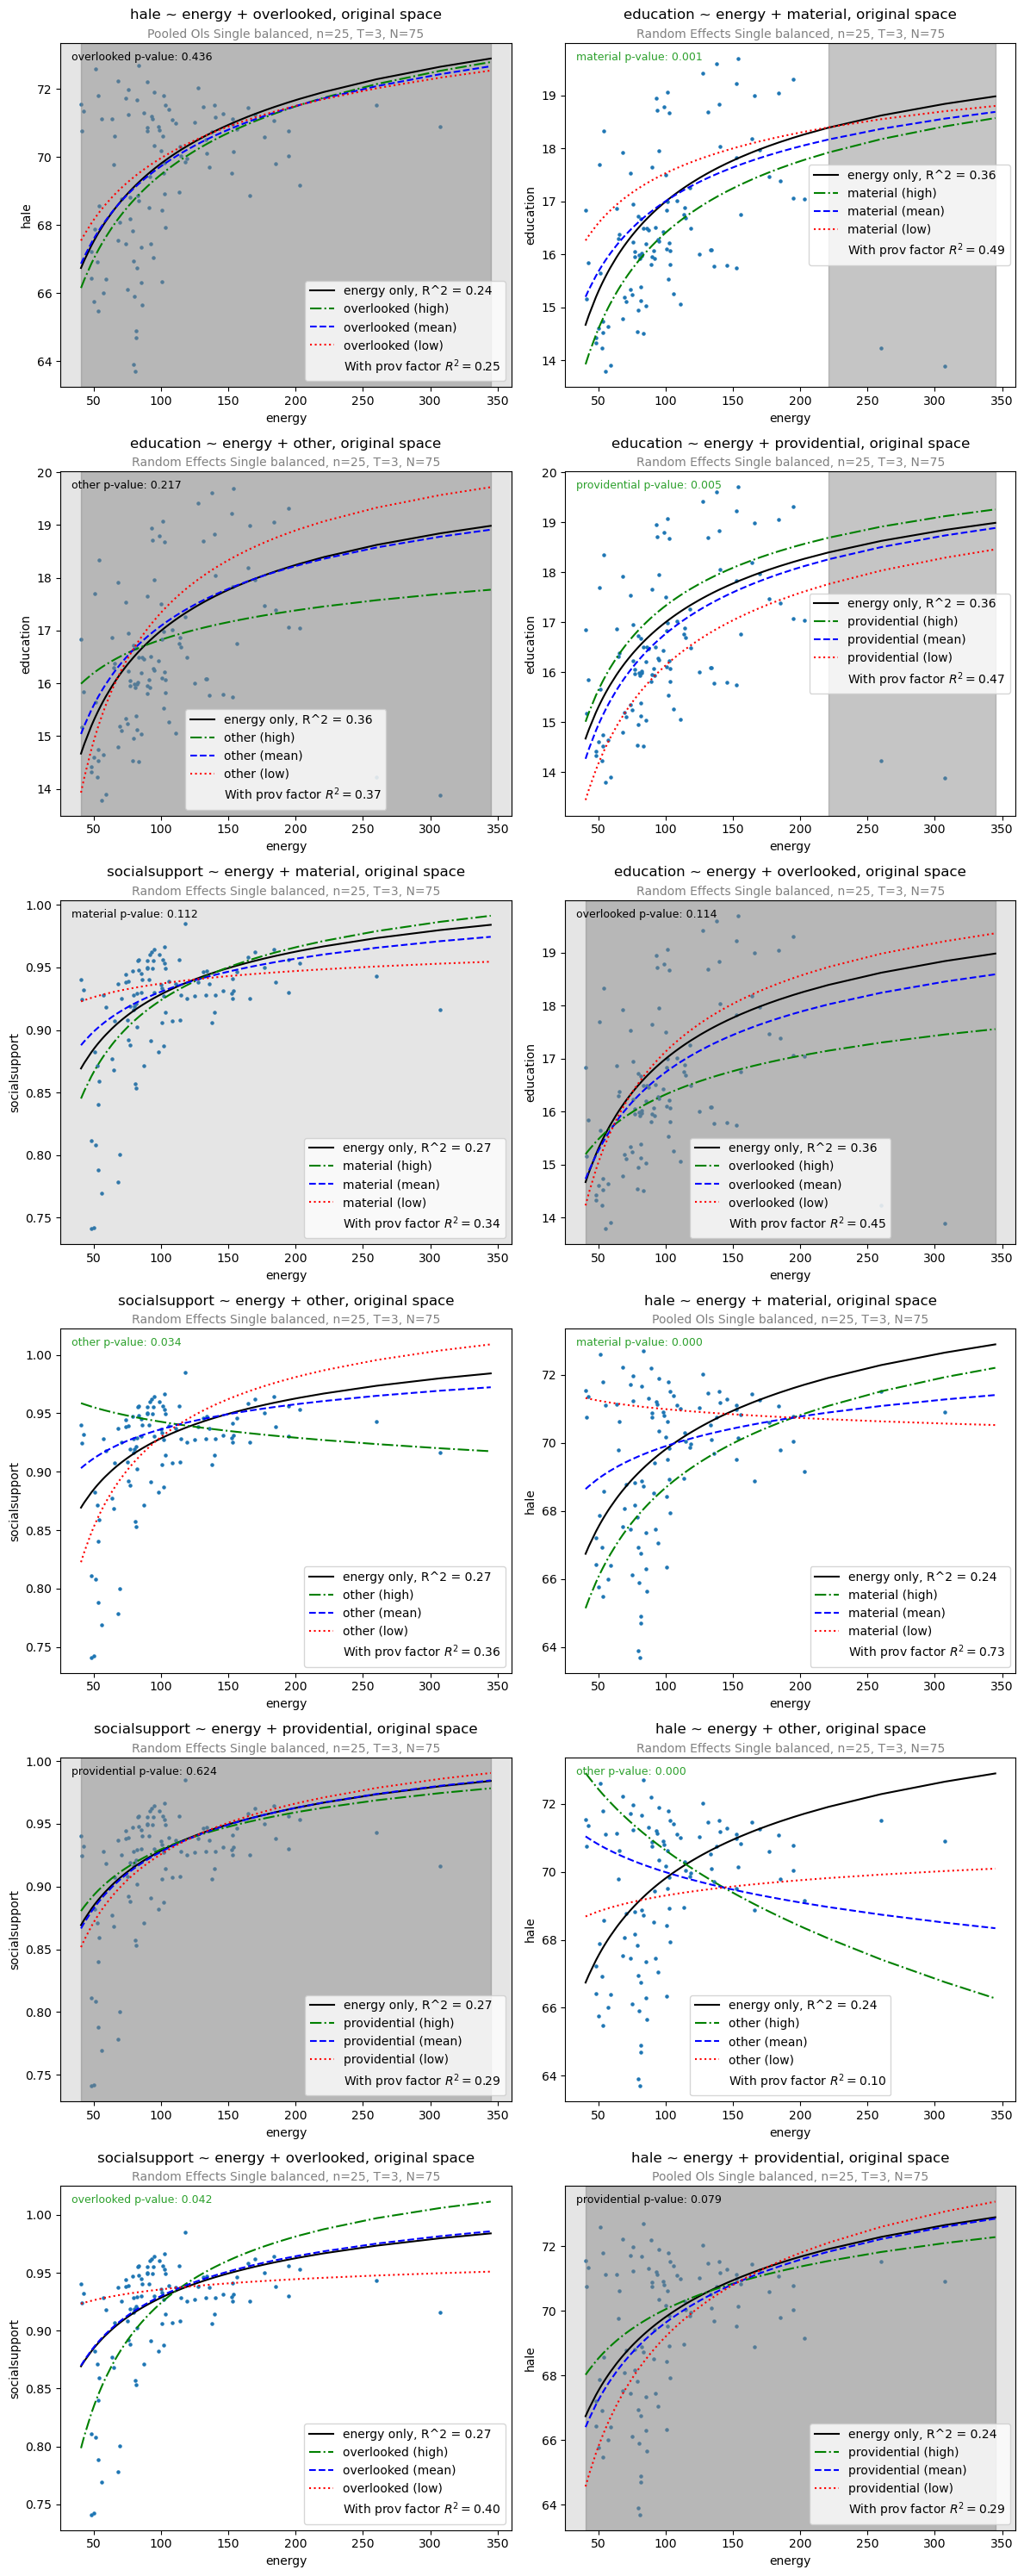

In [477]:
plot_regression_combinations(best_df_regressions, df_regressions_unique_combinations, back_transformed_data, foundational_df_transformed, scaler_df, back_transform=True)

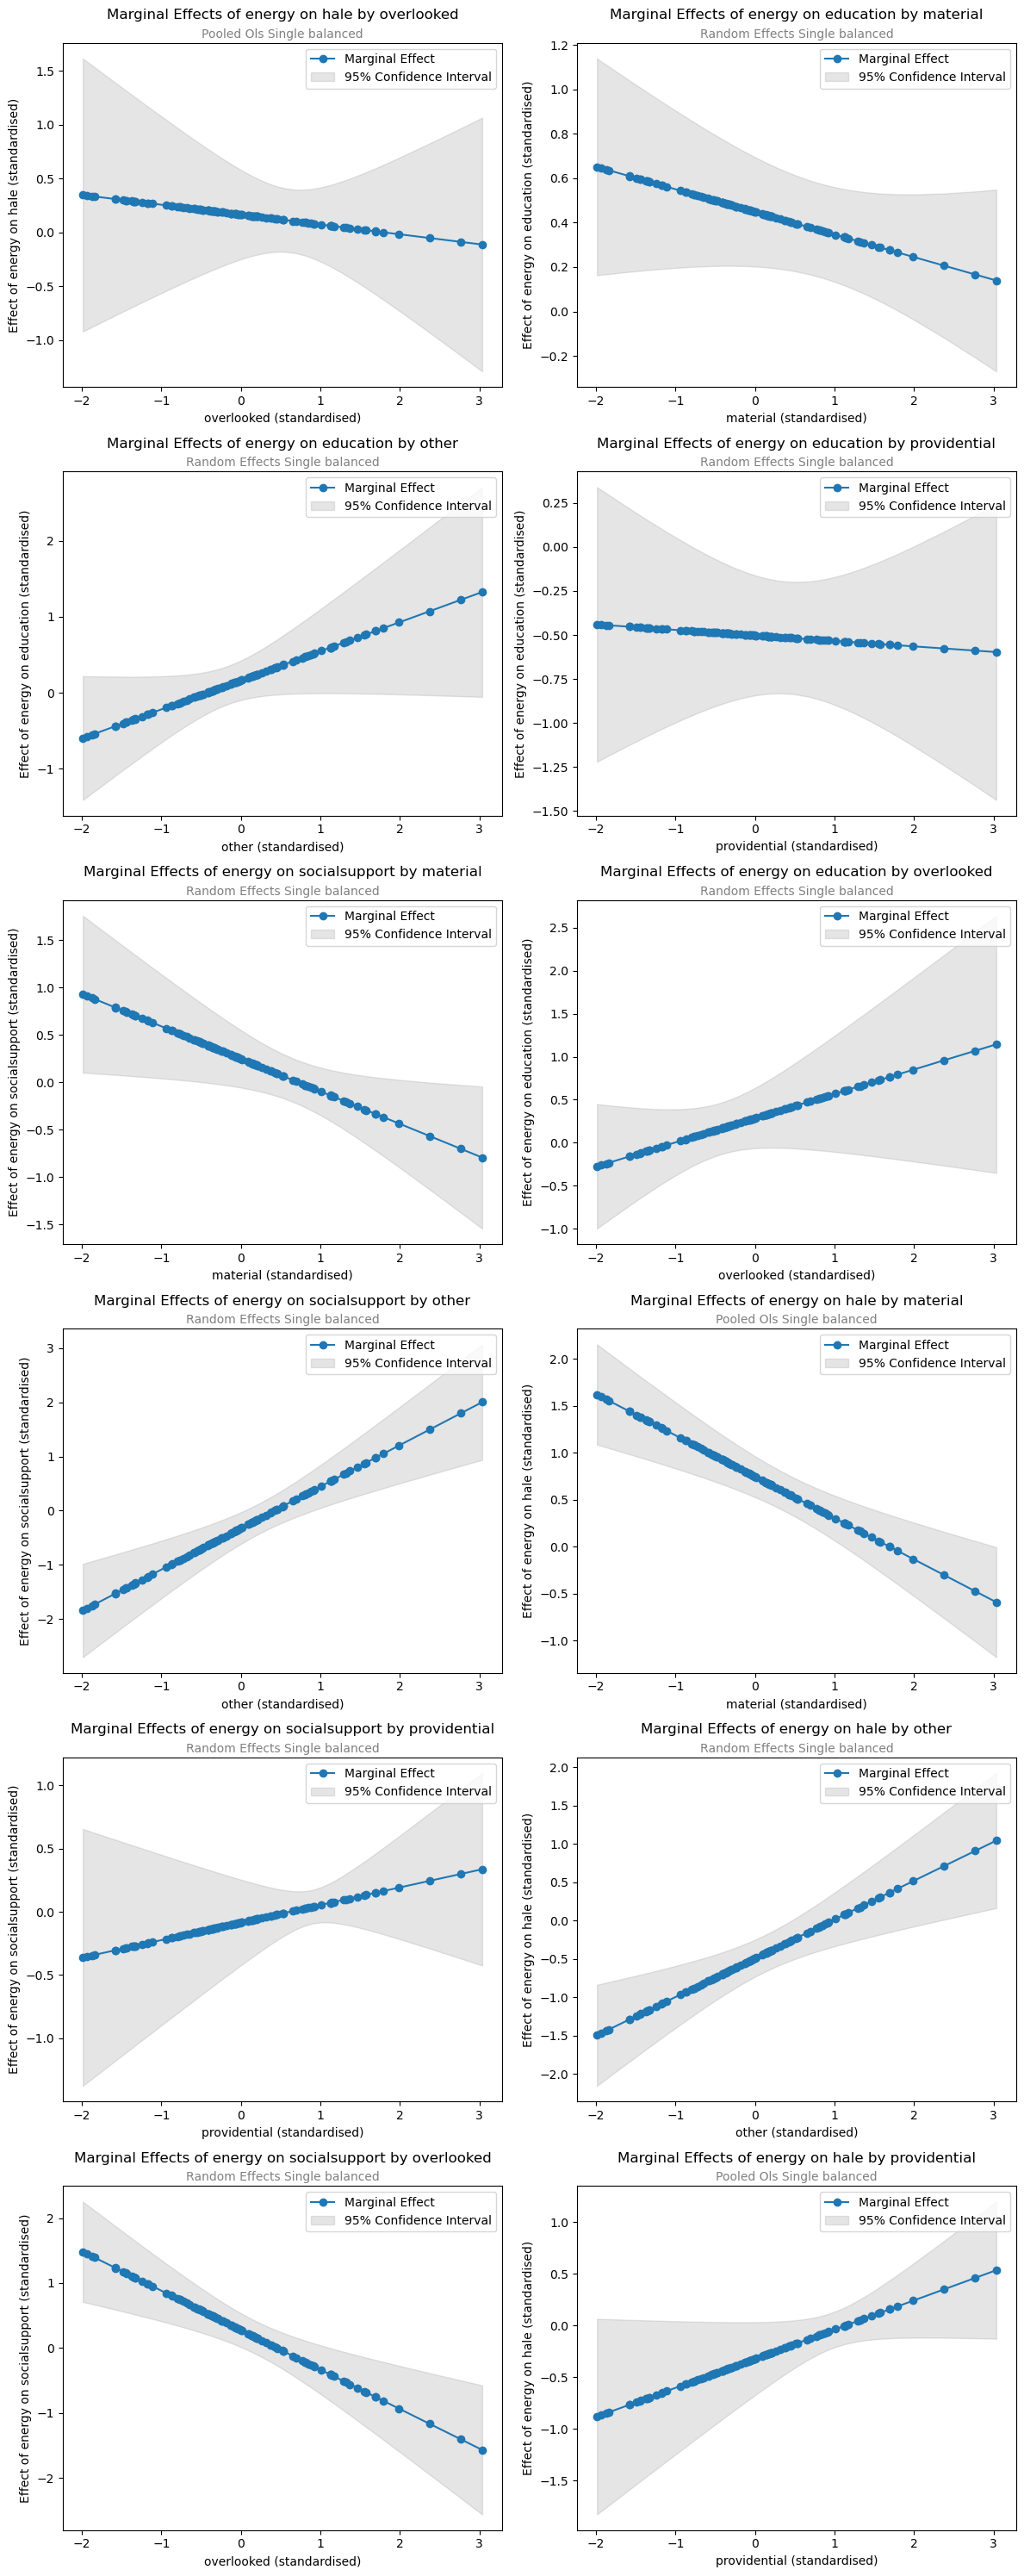

In [476]:
plot_regression_combinations(best_df_regressions, df_regressions_unique_combinations, back_transformed_data, foundational_df_transformed, scaler_df, type='marginal_effects')

## EXIOBASE energy data, Labour Cost Survey labour shares (using this for the thesis)

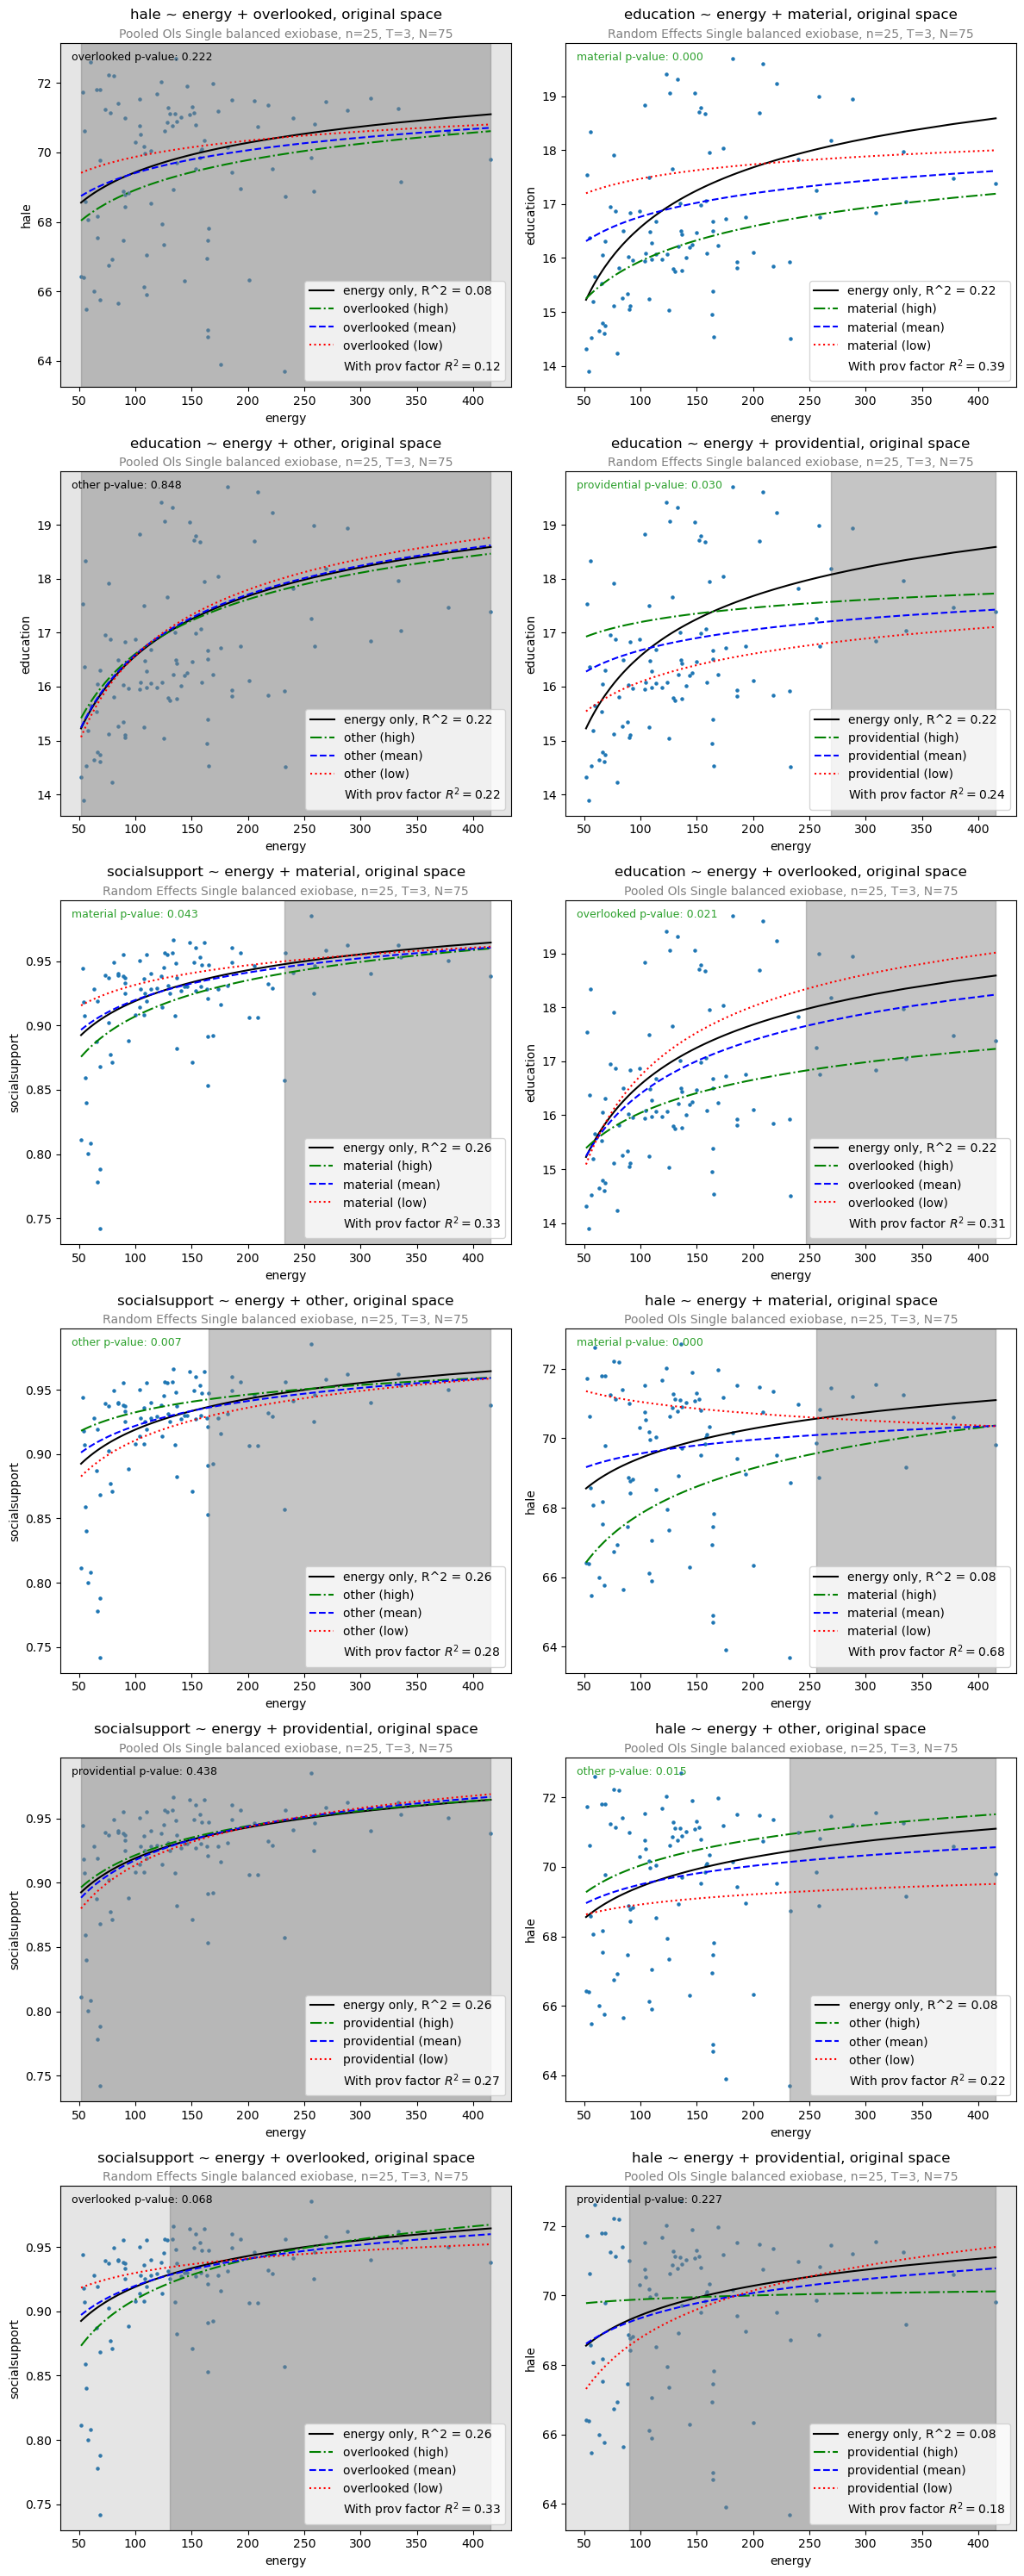

In [478]:
plot_regression_combinations(best_df_regressions_exiobase, df_regressions_exiobase_unique_combinations, back_transformed_data_exiobase, foundational_df_transformed_exiobase, scaler_df_exiobase, back_transform=True)

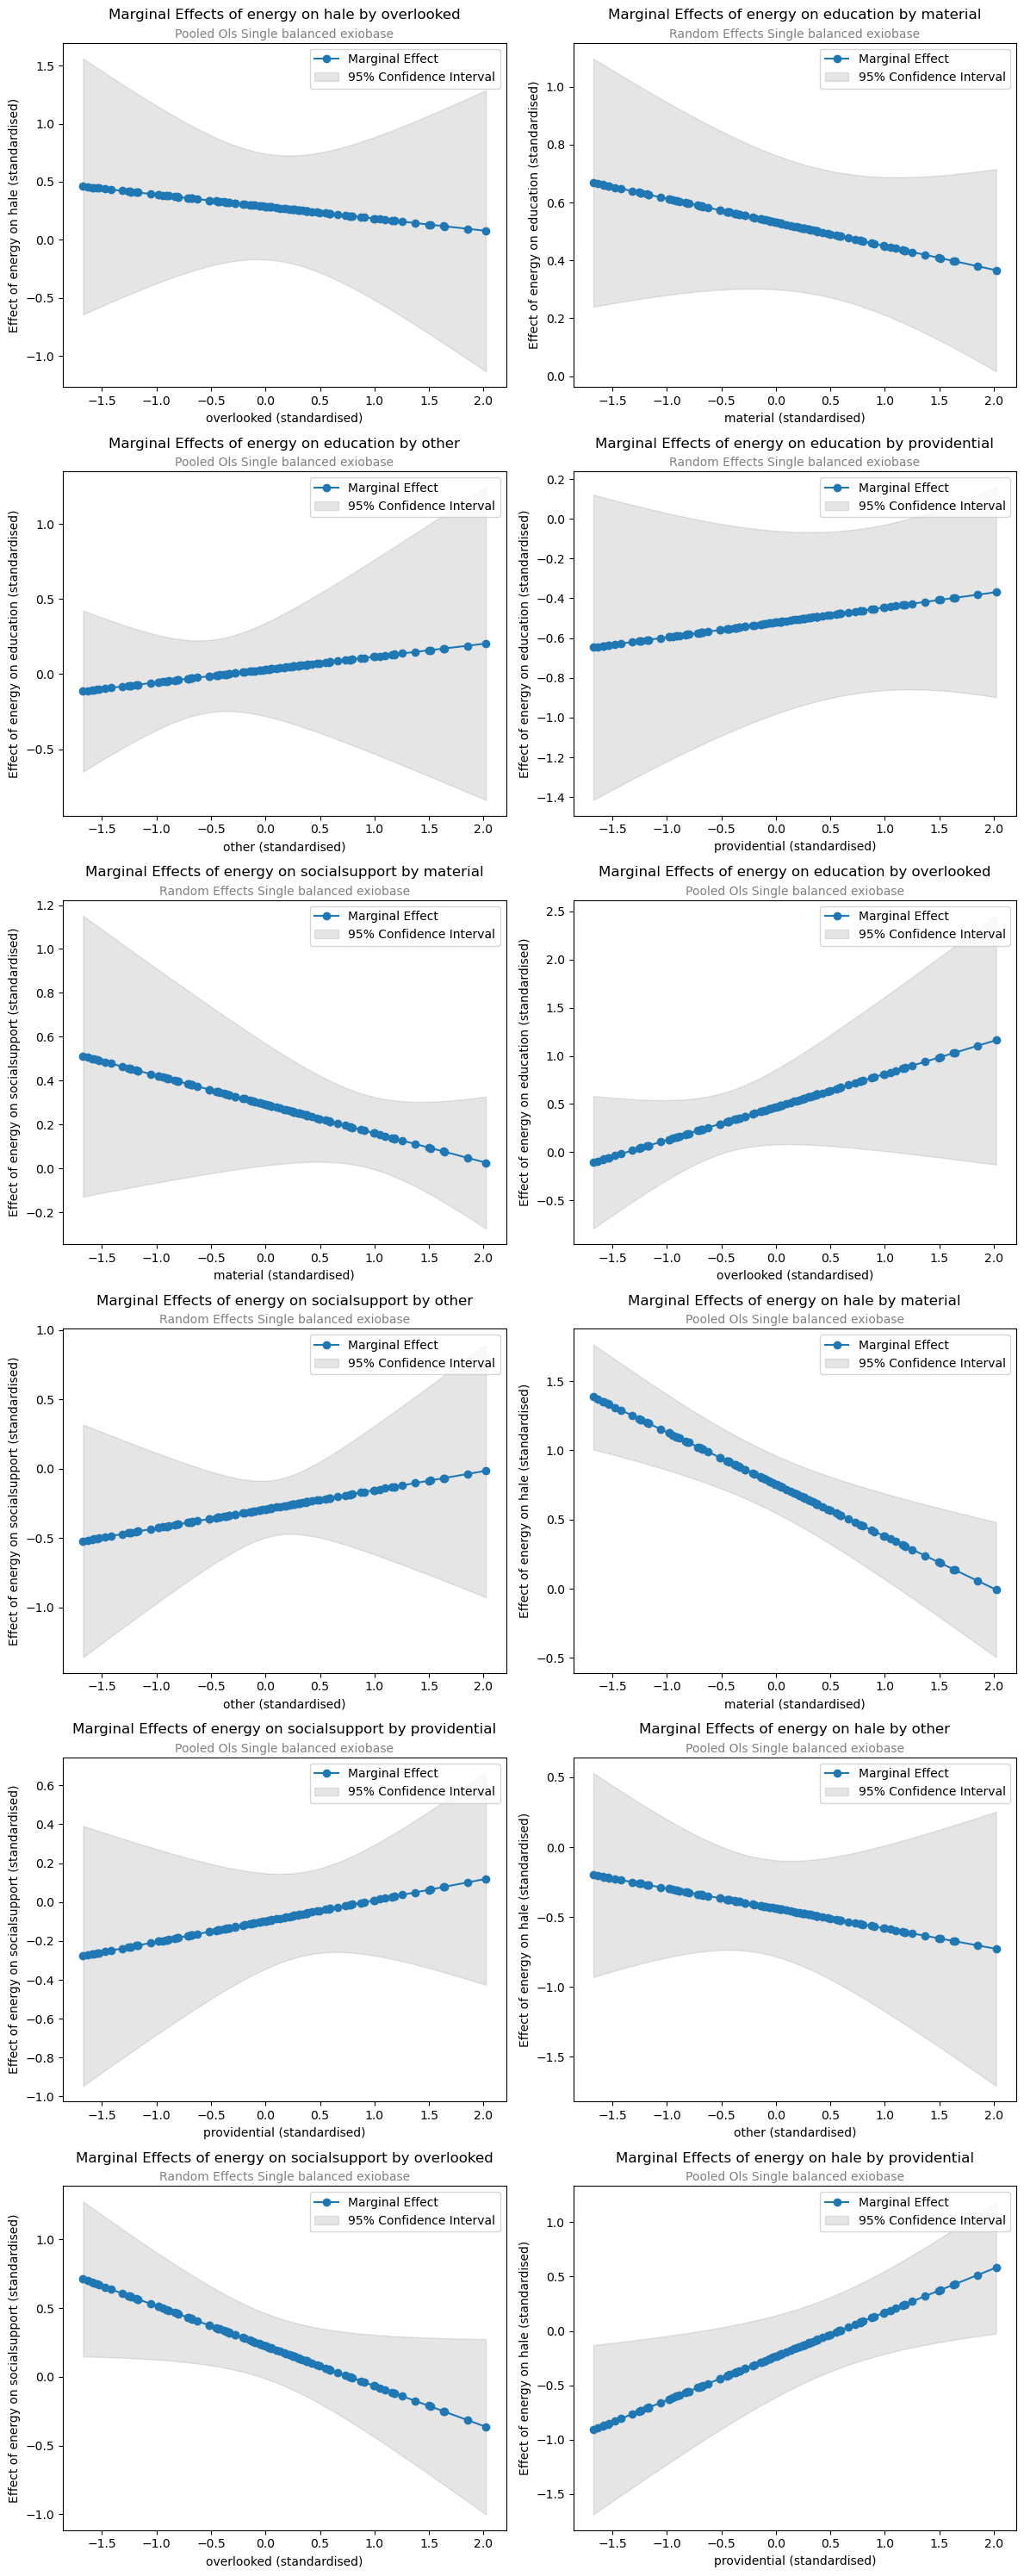

In [479]:
plot_regression_combinations(best_df_regressions_exiobase, df_regressions_exiobase_unique_combinations, back_transformed_data_exiobase, foundational_df_transformed_exiobase, scaler_df_exiobase, type='marginal_effects')